Hi! My name is [Nick Crews](https://www.linkedin.com/in/nicholas-b-crews/),
and I'm a data engineer that looks at public campaign finance data.

In this post, I'll walk through how I use Ibis to explore public campaign contribution
data from the Federal Election Commission (FEC). We'll do some loading,
cleaning, featurizing, and visualization. There will be filtering, sorting, grouping,
and aggregation.

## Downloading The Data

In [1]:
from pathlib import Path
from zipfile import ZipFile
from urllib.request import urlretrieve

# Download and unzip the 2018 individual contributions data
url = "https://cg-519a459a-0ea3-42c2-b7bc-fa1143481f74.s3-us-gov-west-1.amazonaws.com/bulk-downloads/2018/indiv18.zip"
zip_path = Path("indiv18.zip")
csv_path = Path("indiv18.csv")

if not zip_path.exists():
    urlretrieve(url, zip_path)

if not csv_path.exists():
    with ZipFile(zip_path) as zip_file, csv_path.open("w") as csv_file:
        for line in zip_file.open("itcont.txt"):
            csv_file.write(line.decode())

## Loading the data

Now that we have our raw data in a .csv format, let's load it into Ibis,
using the duckdb backend.

Note that a 4.3 GB .csv would be near the limit of what pandas could 
handle on my laptop with 16GB of RAM. In pandas, typically every time
you perform a transformation on the data, a copy of the data is made.
I could only do a few transformations before I ran out of memory.

With Ibis, this problem is solved in two different ways.

First, because they are designed to work with very large datasets,
many (all?) SQL backends support out of core operations.
The data lives on disk, and are only loaded in a streaming fashion
when needed, and then written back to disk as the operation is performed.

Second, unless you explicitly ask for it, Ibis makes use of lazy
evaluation. This means that when you ask for a result, the
result is not persisted in memory. Only the original source
data is persisted. Everything else is derived from this on the fly.

In [2]:
import ibis
from ibis import _

ibis.options.interactive = True

# The raw .csv file doesn't have column names, so we will add them in the next step.
raw = ibis.read_csv(csv_path)
raw

┏━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━┓
┃ column00  ┃ column01 ┃ column02 ┃ column03 ┃ column04           ┃ column05 ┃ column06 ┃ column07          ┃ column08     ┃ column09 ┃ column10  ┃ column11          ┃ column12                ┃ column13 ┃ column14 ┃ column15  ┃ column16        ┃ column17 ┃ column18 ┃ column19                                                        ┃ … ┃
┡━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━┩
│ string    │ string   │ string   │ string   │ int64              │ string   │ string   │ string            │ string       │ string   │ string    │ string            │ string                  │ string   │ int64    │ string    │ string          │ int64    │ string   │ string                                                          │ … │
├───────────┼──────────┼──────────┼──────────┼────────────────────┼──────────┼──────────┼───────────────────┼──────────────┼──────────┼───────────┼───────────────────┼─────────────────────────┼──────────┼──────────┼───────────┼─────────────────┼──────────┼──────────┼─────────────────────────────────────────────────────────────────┼───┤
│ C00401224 │ A        │ M6       │ P        │ 201804059101866001 │ 24T      │ IND      │ STOUFFER, LEIGH   │ AMSTELVEEN   │ ZZ       │ 1187RC    │ MYSELF            │ SELF EMPLOYED           │ 05172017 │       10 │ C00458000 │ SA11AI_81445687 │  1217152 │ ∅        │ EARMARKED FOR PROGRESSIVE CHANGE CAMPAIGN COMMITTEE (C00458000) │ … │
│ C00401224 │ A        │ M6       │ P        │ 201804059101867748 │ 24T      │ IND      │ STRAWS, JOYCE     │ OCOEE        │ FL       │ 34761     │ SILVERSEA CRUISES │ RESERVATIONS SUPERVISOR │ 05182017 │       10 │ C00000935 │ SA11AI_81592336 │  1217152 │ ∅        │ EARMARKED FOR DCCC (C00000935)                                  │ … │
│ C00401224 │ A        │ M6       │ P        │ 201804059101867748 │ 24T      │ IND      │ STRAWS, JOYCE     │ OCOEE        │ FL       │ 34761     │ SILVERSEA CRUISES │ RESERVATIONS SUPERVISOR │ 05192017 │       15 │ C00000935 │ SA11AI_81627562 │  1217152 │ ∅        │ EARMARKED FOR DCCC (C00000935)                                  │ … │
│ C00401224 │ A        │ M6       │ P        │ 201804059101865942 │ 24T      │ IND      │ STOTT, JIM        │ CAPE NEDDICK │ ME       │ 039020760 │ NONE              │ NONE                    │ 05132017 │       35 │ C00000935 │ SA11AI_81047921 │  1217152 │ ∅        │ EARMARKED FOR DCCC (C00000935)                                  │ … │
│ C00401224 │ A        │ M6       │ P        │ 201804059101865942 │ 24T      │ IND      │ STOTT, JIM        │ CAPE NEDDICK │ ME       │ 039020760 │ NONE              │ NONE                    │ 05152017 │       35 │ C00000935 │ SA11AI_81209209 │  1217152 │ ∅        │ EARMARKED FOR DCCC (C00000935)                                  │ … │
│ C00401224 │ A        │ M6       │ P        │ 201804059101865942 │ 24T      │ IND      │ STOTT, JIM        │ CAPE NEDDICK │ ME       │ 039020760 │ NONE              │ NONE                    │ 05192017 │        5 │ C00000935 │ SA11AI_81605223 │  1217152 │ ∅        │ EARMARKED FOR DCCC (C00000935)                                  │ … │
│ C00401224 │ A        │ M6       │ P        │ 201804059101865943 │ 24T      │ IND      │ STOTT, JIM        │ CAPE NEDDICK │ ME       │ 039020760 │ NONE              │ NONE                    │ 05242017 │       15 │ C00000935 │ SA11AI_82200022 │  1217152 │ ∅        │ EARMARKED FOR 

In [3]:
# For a more comprehesive description of the columns and their meaning, see
# https://www.fec.gov/campaign-finance-data/contributions-individuals-file-description/
columns = {
    "CMTE_ID": "keep",  # Committee ID
    "AMNDT_IND": "drop",  # Amendment indicator. A = amendment, N = new, T = termination
    "RPT_TP": "drop",  # Report type (monthly, quarterly, etc)
    "TRANSACTION_PGI": "keep",  # Primary/general indicator
    "IMAGE_NUM": "drop",  # Image number
    "TRANSACTION_TP": "drop",  # Transaction type
    "ENTITY_TP": "keep",  # Entity type
    "NAME": "drop",  # Contributor name
    "CITY": "keep",  # Contributor city
    "STATE": "keep",  # Contributor state
    "ZIP_CODE": "drop",  # Contributor zip code
    "EMPLOYER": "drop",  # Contributor employer
    "OCCUPATION": "drop",  # Contributor occupation
    "TRANSACTION_DT": "keep",  # Transaction date
    "TRANSACTION_AMT": "keep",  # Transaction amount
    # Other ID. For individual contributions will be null. For contributions from
    # other FEC committees, will be the committee ID of the other committee.
    "OTHER_ID": "drop",
    "TRAN_ID": "drop",  # Transaction ID
    "FILE_NUM": "drop",  # File number, unique number assigned to each report filed with the FEC
    "MEMO_CD": "drop",  # Memo code
    "MEMO_TEXT": "drop",  # Memo text
    "SUB_ID": "drop",  # Submission ID. Unique number assigned to each transaction.
}

renaming = {old: new for old, new in zip(raw.columns, columns.keys())}
to_keep = [k for k, v in columns.items() if v == "keep"]
kept = raw.relabel(renaming)[to_keep]
kept

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ CMTE_ID   ┃ TRANSACTION_PGI ┃ ENTITY_TP ┃ CITY         ┃ STATE  ┃ TRANSACTION_DT ┃ TRANSACTION_AMT ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ string    │ string          │ string    │ string       │ string │ string         │ int64           │
├───────────┼─────────────────┼───────────┼──────────────┼────────┼────────────────┼─────────────────┤
│ C00401224 │ P               │ IND       │ AMSTELVEEN   │ ZZ     │ 05172017       │              10 │
│ C00401224 │ P               │ IND       │ OCOEE        │ FL     │ 05182017       │              10 │
│ C00401224 │ P               │ IND       │ OCOEE        │ FL     │ 05192017       │              15 │
│ C00401224 │ P               │ IND       │ CAPE NEDDICK │ ME     │ 05132017       │              35 │
│ C00401224 │ P               │ IND       │ CAPE NEDDICK │ ME     │ 05152017       │              35 │
│ C00401224 │ P               │ IND       │ CAPE NEDDICK │ ME     │ 05192017       │               5 │
│ C00401224 │ P               │ IND       │ CAPE NEDDICK │ ME     │ 05242017       │              15 │
│ C00401224 │ P               │ IND       │ CAPE NEDDICK │ ME     │ 05292017       │             100 │
│ C00401224 │ P               │ IND       │ CAPE NEDDICK │ ME     │ 05302017       │              35 │
│ C00401224 │ P               │ IND       │ ANNA MSRIA   │ FL     │ 05162017       │              25 │
│ …         │ …               │ …         │ …            │ …      │ …              │               … │
└───────────┴─────────────────┴───────────┴──────────────┴────────┴────────────────┴─────────────────┘

In [4]:
# 21 million rows
kept.count()

21730731

Huh, what's up with those timings? Previewing the head only took a fraction of a second,
but finding the number of rows took 10 seconds.

That's because duckdb is scanning the .csv file on the fly every time we access it.
So we only have to read the first few lines to get that preview,
but we have to read the whole file to get the number of rows.

Note that this isn't a feature of Ibis, but a feature of Duckdb. This what I think is
one of the strengths of Ibis: Ibis itself doesn't have to implement any of the 
optimimizations or features of the backends. Those backends can focus on what they do
best, and Ibis can get those things for free.

So, let's tell duckdb to actually read in the file to its native format so later accesses
will be faster. This will be a ~20 seconds that we'll only have to pay once.

In [5]:
kept = kept.cache()
kept

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ CMTE_ID   ┃ TRANSACTION_PGI ┃ ENTITY_TP ┃ CITY         ┃ STATE  ┃ TRANSACTION_DT ┃ TRANSACTION_AMT ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ string    │ string          │ string    │ string       │ string │ string         │ int64           │
├───────────┼─────────────────┼───────────┼──────────────┼────────┼────────────────┼─────────────────┤
│ C00401224 │ P               │ IND       │ AMSTELVEEN   │ ZZ     │ 05172017       │              10 │
│ C00401224 │ P               │ IND       │ OCOEE        │ FL     │ 05182017       │              10 │
│ C00401224 │ P               │ IND       │ OCOEE        │ FL     │ 05192017       │              15 │
│ C00401224 │ P               │ IND       │ CAPE NEDDICK │ ME     │ 05132017       │              35 │
│ C00401224 │ P               │ IND       │ CAPE NEDDICK │ ME     │ 05152017       │              35 │
│ C00401224 │ P               │ IND       │ CAPE NEDDICK │ ME     │ 05192017       │               5 │
│ C00401224 │ P               │ IND       │ CAPE NEDDICK │ ME     │ 05242017       │              15 │
│ C00401224 │ P               │ IND       │ CAPE NEDDICK │ ME     │ 05292017       │             100 │
│ C00401224 │ P               │ IND       │ CAPE NEDDICK │ ME     │ 05302017       │              35 │
│ C00401224 │ P               │ IND       │ ANNA MSRIA   │ FL     │ 05162017       │              25 │
│ …         │ …               │ …         │ …            │ …      │ …              │               … │
└───────────┴─────────────────┴───────────┴──────────────┴────────┴────────────────┴─────────────────┘

Look, now accessing it only takes a fraction of a second!

In [6]:
kept.count()

21730731

### Committees Data

The contributions only list an opaque `CMTE_ID` column. We want to know which actual
committee this is. Let's load the committees table so we can lookup from
committee ID to committee name.

In [7]:
def read_committees():
    committees_url = "https://cg-519a459a-0ea3-42c2-b7bc-fa1143481f74.s3-us-gov-west-1.amazonaws.com/bulk-downloads/2018/committee_summary_2018.csv"
    # This just creates a view, it doesn't actually fetch the data yet
    tmp = ibis.read_csv(committees_url)
    tmp = tmp["CMTE_ID", "CMTE_NM"]
    # The raw table contains multiple rows for each committee id, so lets pick
    # an arbitrary row for each committee id as the representative name.
    deduped = tmp.group_by("CMTE_ID").agg(CMTE_NM=_.CMTE_NM.arbitrary())
    return deduped


comms = read_committees().cache()
comms

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ CMTE_ID   ┃ CMTE_NM                                  ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string    │ string                                   │
├───────────┼──────────────────────────────────────────┤
│ C00097238 │ VIAD CORP GOOD GOVERNMENT PROJECT        │
│ C00497859 │ HALL FOR CONGRESS                        │
│ C00639914 │ TOM K. PAPPAS FOR CONGRESS               │
│ C00663401 │ ENGAGING LEADERS OF THE FUTURE PAC       │
│ C00020453 │ CASS COUNTY REPUBLICAN CENTRAL COMMITTEE │
│ C00591909 │ RODNEY FRELINGHUYSEN VICTORY FUND        │
│ C00635094 │ CAPITO VICTORY COMMITTEE                 │
│ C00658310 │ ROBERT BARR FOR CONGRESS                 │
│ C00657965 │ NEW ELECTORATE                           │
│ C00485045 │ DISTRICT COUNCIL 9 POLITICAL ACTION FUND │
│ …         │ …                                        │
└───────────┴──────────────────────────────────────────┘

Now add a the committee name to the contributions table:

In [8]:
together = kept.left_join(comms, "CMTE_ID").drop("CMTE_ID_x", "CMTE_ID_y")
together

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ TRANSACTION_PGI ┃ ENTITY_TP ┃ CITY         ┃ STATE  ┃ TRANSACTION_DT ┃ TRANSACTION_AMT ┃ CMTE_NM ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ string          │ string    │ string       │ string │ string         │ int64           │ string  │
├─────────────────┼───────────┼──────────────┼────────┼────────────────┼─────────────────┼─────────┤
│ P               │ IND       │ AMSTELVEEN   │ ZZ     │ 05172017       │              10 │ ACTBLUE │
│ P               │ IND       │ OCOEE        │ FL     │ 05182017       │              10 │ ACTBLUE │
│ P               │ IND       │ OCOEE        │ FL     │ 05192017       │              15 │ ACTBLUE │
│ P               │ IND       │ CAPE NEDDICK │ ME     │ 05132017       │              35 │ ACTBLUE │
│ P               │ IND       │ CAPE NEDDICK │ ME     │ 05152017       │              35 │ ACTBLUE │
│ P               │ IND       │ CAPE NEDDICK │ ME     │ 05192017       │               5 │ ACTBLUE │
│ P               │ IND       │ CAPE NEDDICK │ ME     │ 05242017       │              15 │ ACTBLUE │
│ P               │ IND       │ CAPE NEDDICK │ ME     │ 05292017       │             100 │ ACTBLUE │
│ P               │ IND       │ CAPE NEDDICK │ ME     │ 05302017       │              35 │ ACTBLUE │
│ P               │ IND       │ ANNA MSRIA   │ FL     │ 05162017       │              25 │ ACTBLUE │
│ …               │ …         │ …            │ …      │ …              │               … │ …       │
└─────────────────┴───────────┴──────────────┴────────┴────────────────┴─────────────────┴─────────┘

## Cleaning

First, let's drop any contributions that don't have a committee name. There are only 6 of them.

In [9]:
# We can do this fearlessly, no .copy() needed, because
# everything in Ibis is immutable. If we did this in pandas,
# we might start modifying the original DataFrame accidentally!
cleaned = together

has_name = cleaned.CMTE_NM.notnull()
cleaned = cleaned[has_name]
has_name.value_counts()

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ NotNull(CMTE_NM) ┃ NotNull(CMTE_NM)_count ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ boolean          │ int64                  │
├──────────────────┼────────────────────────┤
│ True             │               21730725 │
│ False            │                      6 │
└──────────────────┴────────────────────────┘

Let's look at the `ENTITY_TP` column. This represents the type of entity that
made the contribution:

In [10]:
together.ENTITY_TP.value_counts()

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ ENTITY_TP ┃ ENTITY_TP_count ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ string    │ int64           │
├───────────┼─────────────────┤
│ IND       │        21687993 │
│ ORG       │           18555 │
│ CAN       │           13659 │
│ PAC       │            3621 │
│ ∅         │            5289 │
│ COM       │             867 │
│ PTY       │              49 │
│ CCM       │             698 │
└───────────┴─────────────────┘

We only care about contributions from individuals.

Once we filter on this column, the contents of it are irrelevant, so let's drop it.

In [11]:
cleaned = together[_.ENTITY_TP == "IND"].drop("ENTITY_TP")

It looks like the `TRANSACTION_DT` column was a raw string like "MMDDYYYY", 
so let's convert that to a proper date type.

In [12]:
from ibis.expr.types import StringValue, DateValue


def mmddyyyy_to_date(val: StringValue) -> DateValue:
    return val.cast(str).lpad(8, "0").to_timestamp("%m%d%Y").date()


cleaned = cleaned.mutate(date=mmddyyyy_to_date(_.TRANSACTION_DT)).drop("TRANSACTION_DT")
cleaned

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┓
┃ TRANSACTION_PGI ┃ CITY         ┃ STATE  ┃ TRANSACTION_AMT ┃ CMTE_NM ┃ date       ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━┩
│ string          │ string       │ string │ int64           │ string  │ date       │
├─────────────────┼──────────────┼────────┼─────────────────┼─────────┼────────────┤
│ P               │ AMSTELVEEN   │ ZZ     │              10 │ ACTBLUE │ 2017-05-17 │
│ P               │ OCOEE        │ FL     │              10 │ ACTBLUE │ 2017-05-18 │
│ P               │ OCOEE        │ FL     │              15 │ ACTBLUE │ 2017-05-19 │
│ P               │ CAPE NEDDICK │ ME     │              35 │ ACTBLUE │ 2017-05-13 │
│ P               │ CAPE NEDDICK │ ME     │              35 │ ACTBLUE │ 2017-05-15 │
│ P               │ CAPE NEDDICK │ ME     │               5 │ ACTBLUE │ 2017-05-19 │
│ P               │ CAPE NEDDICK │ ME     │              15 │ ACTBLUE │ 2017-05-24 │
│ P               │ CAPE NEDDICK │ ME     │             100 │ ACTBLUE │ 2017-05-29 │
│ P               │ CAPE NEDDICK │ ME     │              35 │ ACTBLUE │ 2017-05-30 │
│ P               │ ANNA MSRIA   │ FL     │              25 │ ACTBLUE │ 2017-05-16 │
│ …               │ …            │ …      │               … │ …       │ …          │
└─────────────────┴──────────────┴────────┴─────────────────┴─────────┴────────────┘

The `TRANSACTION_PGI` column represents the type (primary, general, etc) of election,
and the year. But it seems to be not very consistent:

In [13]:
cleaned.TRANSACTION_PGI.topk(10)

┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ TRANSACTION_PGI ┃ count    ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ string          │ int64    │
├─────────────────┼──────────┤
│ P               │ 17013597 │
│ G2018           │  2095123 │
│ P2018           │  1677183 │
│ P2020           │   208501 │
│ O2018           │   161874 │
│ S2017           │   124336 │
│ G2017           │    98401 │
│ P2022           │    91136 │
│ P2017           │    61153 │
│ R2017           │    54281 │
└─────────────────┴──────────┘

In [14]:
def get_election_type(pgi: StringValue) -> StringValue:
    """Use the first letter of the TRANSACTION_PGI column to determine the election type

    If the first letter is not one of the known election stage, then return null.
    """
    election_types = {
        "P": "primary",
        "G": "general",
        "O": "other",
        "C": "convention",
        "R": "runoff",
        "S": "special",
        "E": "recount",
    }
    first_letter = pgi[0]
    return first_letter.substitute(election_types, else_=ibis.NA)


cleaned = cleaned.mutate(election_type=get_election_type(_.TRANSACTION_PGI)).drop(
    "TRANSACTION_PGI"
)
cleaned

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ CITY         ┃ STATE  ┃ TRANSACTION_AMT ┃ CMTE_NM ┃ date       ┃ election_type ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ string       │ string │ int64           │ string  │ date       │ string        │
├──────────────┼────────┼─────────────────┼─────────┼────────────┼───────────────┤
│ AMSTELVEEN   │ ZZ     │              10 │ ACTBLUE │ 2017-05-17 │ primary       │
│ OCOEE        │ FL     │              10 │ ACTBLUE │ 2017-05-18 │ primary       │
│ OCOEE        │ FL     │              15 │ ACTBLUE │ 2017-05-19 │ primary       │
│ CAPE NEDDICK │ ME     │              35 │ ACTBLUE │ 2017-05-13 │ primary       │
│ CAPE NEDDICK │ ME     │              35 │ ACTBLUE │ 2017-05-15 │ primary       │
│ CAPE NEDDICK │ ME     │               5 │ ACTBLUE │ 2017-05-19 │ primary       │
│ CAPE NEDDICK │ ME     │              15 │ ACTBLUE │ 2017-05-24 │ primary       │
│ CAPE NEDDICK │ ME     │             100 │ ACTBLUE │ 2017-05-29 │ primary       │
│ CAPE NEDDICK │ ME     │              35 │ ACTBLUE │ 2017-05-30 │ primary       │
│ ANNA MSRIA   │ FL     │              25 │ ACTBLUE │ 2017-05-16 │ primary       │
│ …            │ …      │               … │ …       │ …          │ …             │
└──────────────┴────────┴─────────────────┴─────────┴────────────┴───────────────┘

That worked well! There are 0 nulls in the resulting column, so we always were
able to determine the election type.

In [15]:
cleaned.election_type.topk(10)

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ election_type ┃ count    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ string        │ int64    │
├───────────────┼──────────┤
│ primary       │ 19061954 │
│ general       │  2216685 │
│ other         │   161965 │
│ special       │   149572 │
│ runoff        │    69637 │
│ convention    │    22453 │
│ recount       │     5063 │
│ ∅             │        0 │
└───────────────┴──────────┘

About 1/20 of transactions are negative. These could represent refunds, or they could be data
entry errors. Let's simply drop them to keep it simple.

In [16]:
above_zero = cleaned.TRANSACTION_AMT > 0
cleaned = cleaned[above_zero]
above_zero.value_counts()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Greater(TRANSACTION_AMT, 0) ┃ Greater(TRANSACTION_AMT, 0)_count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ boolean                     │ int64                             │
├─────────────────────────────┼───────────────────────────────────┤
│ True                        │                          20669810 │
│ False                       │                           1018183 │
└─────────────────────────────┴───────────────────────────────────┘

## Adding Features

Now that the data is cleaned up to a usable format, let's add some features.

First, it's useful to categorize donations by size, placing them into buckets
of small, medium, large, etc.

In [17]:
edges = [
    10,
    50,
    100,
    500,
    1000,
    5000,
]
labels = [
    "<10",
    "10-50",
    "50-100",
    "100-500",
    "500-1000",
    "1000-5000",
    "5000+",
]


def bucketize(vals, edges, str_labels):
    # Uses Ibis's .bucket() method to create a categorical column
    int_labels = vals.bucket(edges, include_under=True, include_over=True)
    # Map the integer labels to the string labels
    int_to_str = {str(i): s for i, s in enumerate(str_labels)}
    return int_labels.cast(str).substitute(int_to_str)


featured = cleaned.mutate(amount_bucket=bucketize(_.TRANSACTION_AMT, edges, labels))
featured

┏━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ CITY         ┃ STATE  ┃ TRANSACTION_AMT ┃ CMTE_NM ┃ date       ┃ election_type ┃ amount_bucket ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ string       │ string │ int64           │ string  │ date       │ string        │ string        │
├──────────────┼────────┼─────────────────┼─────────┼────────────┼───────────────┼───────────────┤
│ AMSTELVEEN   │ ZZ     │              10 │ ACTBLUE │ 2017-05-17 │ primary       │ 10-50         │
│ OCOEE        │ FL     │              10 │ ACTBLUE │ 2017-05-18 │ primary       │ 10-50         │
│ OCOEE        │ FL     │              15 │ ACTBLUE │ 2017-05-19 │ primary       │ 10-50         │
│ CAPE NEDDICK │ ME     │              35 │ ACTBLUE │ 2017-05-13 │ primary       │ 10-50         │
│ CAPE NEDDICK │ ME     │              35 │ ACTBLUE │ 2017-05-15 │ primary       │ 10-50         │
│ CAPE NEDDICK │ ME     │               5 │ ACTBLUE │ 2017-05-19 │ primary       │ <10           │
│ CAPE NEDDICK │ ME     │              15 │ ACTBLUE │ 2017-05-24 │ primary       │ 10-50         │
│ CAPE NEDDICK │ ME     │             100 │ ACTBLUE │ 2017-05-29 │ primary       │ 100-500       │
│ CAPE NEDDICK │ ME     │              35 │ ACTBLUE │ 2017-05-30 │ primary       │ 10-50         │
│ ANNA MSRIA   │ FL     │              25 │ ACTBLUE │ 2017-05-16 │ primary       │ 10-50         │
│ …            │ …      │               … │ …       │ …          │ …             │ …             │
└──────────────┴────────┴─────────────────┴─────────┴────────────┴───────────────┴───────────────┘

## Analysis

### By donation size

One thing we can look at is the donation breakdown by size:
- Are most donations small or large?
- Where do politicians/committees get most of their money from? Large or small donations?

We also will compare performance of Ibis vs pandas during this groupby.

In [18]:
def summary_by(table, by):
    return table.group_by(by).agg(
        n_donations=_.count(),
        total_amount=_.TRANSACTION_AMT.sum(),
        mean_amount=_.TRANSACTION_AMT.mean(),
        median_amount=_.TRANSACTION_AMT.approx_median(),
    )


def summary_by_pandas(df, by):
    return df.groupby(by, as_index=False).agg(
        n_donations=("election_type", "count"),
        total_amount=("TRANSACTION_AMT", "sum"),
        mean_amount=("TRANSACTION_AMT", "mean"),
        median_amount=("TRANSACTION_AMT", "median"),
    )


# persist the input data so the following timings of the group_by are accurate.
subset = featured["election_type", "amount_bucket", "TRANSACTION_AMT"]
subset = subset.cache()
pandas_subset = subset.execute()

Let's take a look at what we are actually computing:

In [19]:
by_type_and_bucket = summary_by(subset, ["election_type", "amount_bucket"])
by_type_and_bucket

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ election_type ┃ amount_bucket ┃ n_donations ┃ total_amount ┃ mean_amount  ┃ median_amount ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ string        │ string        │ int64       │ int64        │ float64      │ int64         │
├───────────────┼───────────────┼─────────────┼──────────────┼──────────────┼───────────────┤
│ primary       │ 10-50         │     8115404 │    187666261 │    23.124697 │            25 │
│ primary       │ 50-100        │     2663933 │    155426540 │    58.344763 │            50 │
│ primary       │ 100-500       │     3636287 │    637353634 │   175.275943 │           150 │
│ primary       │ <10           │     2423728 │     10080721 │     4.159180 │             5 │
│ primary       │ 500-1000      │      634677 │    334630687 │   527.245649 │           500 │
│ primary       │ 1000-5000     │      684755 │   1231394874 │  1798.299938 │          1005 │
│ general       │ 1000-5000     │      246101 │    460025242 │  1869.253851 │          1965 │
│ general       │ 100-500       │      700821 │    123174568 │   175.757530 │           150 │
│ general       │ 500-1000      │      174182 │     91015697 │   522.532162 │           500 │
│ primary       │ 5000+         │       44085 │   1558371116 │ 35349.237065 │         10000 │
│ …             │ …             │           … │            … │            … │             … │
└───────────────┴───────────────┴─────────────┴──────────────┴──────────────┴───────────────┘

OK, now let's do our timings.

One interesting thing to pay attention to here is the execution time for the following
groupby. Before, we could get away with lazy execution: because we only wanted to preview
the first few rows, we only had to compute the first few rows, so all our previews were
very fast.

But now, as soon as we do a groupby, we have to actually go through the whole dataset
in order to compute the aggregate per group. So this is going to be slower. BUT,
duckdb is still quite fast. It only takes .4 seconds to groupby-agg all 20 million rows!

In [20]:
%timeit summary_by(subset, ["election_type", "amount_bucket"]).execute()  # .execute() so we actually fetch the data

532 ms ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now let's try the same thing in pandas:

In [21]:
%timeit summary_by_pandas(pandas_subset, ["election_type", "amount_bucket"])

5.03 s ± 222 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It takes about 4 seconds, which is about 10 times slower than duckdb.
At this scale, it again doesn't matter,
but you could imagine with a dataset much larger than this, it would matter.

Let's also think about memory usage:

In [22]:
pandas_subset.memory_usage(deep=True).sum() / 1e9  # GB

2.782586797

The source dataframe is couple gigabytes, so probably during the groupby,
the peak memory usage is going to be a bit higher than this. You could use a profiler
such as [FIL](https://github.com/pythonspeed/filprofiler) if you wanted an exact number,
I was too lazy to use that here.

Again, this works on my laptop at this dataset size, but much larger than this and I'd
start having problems. Duckdb on the other hand is designed around working out of core
so it should scale to datasets into the hundreds of gigabytes, much larger than your
computer's RAM.

### Back to analysis

OK, let's plot the result of that groupby.

Surprise! (Or maybe not...) Most donations are small. But most of the money comes
from donations larger than $1000.

Well if that's the case, why do politicians spend so much time soliciting small
donations? One explanation is that they can use the number of donations
as a marketing pitch, to show how popular they are, and thus how viable of a
candidate they are.

This also might explain whose interests are being served by our politicians.

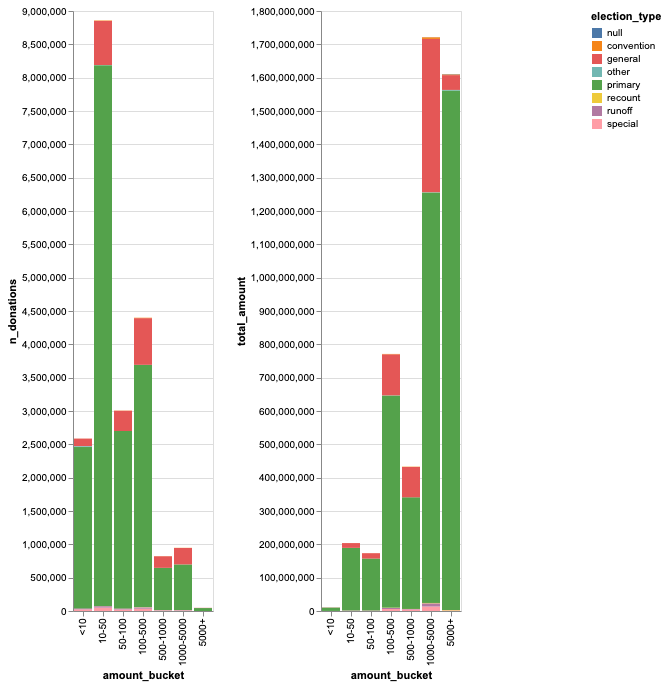

In [23]:
import altair as alt

# Save as .svg so we can embed in the docs, normally not needed if in a notebook.
# This import is needed to add chromedriver to PATH so that altair_saver can find it.
import chromedriver_binary
alt.renderers.enable("png")
alt.renderers.set_embed_options(width=500, height=600)

# Do some bookkeeping so the buckets are displayed smallest to largest on the charts
bucket_col = alt.Column("amount_bucket:N", sort=labels)

n_by_bucket = (
    alt.Chart(by_type_and_bucket.execute())
    .mark_bar()
    .encode(
        x=bucket_col,
        y="n_donations:Q",
        color="election_type:N",
    )
)
total_by_bucket = (
    alt.Chart(by_type_and_bucket.execute())
    .mark_bar()
    .encode(
        x=bucket_col,
        y="total_amount:Q",
        color="election_type:N",
    )
)
n_by_bucket | total_by_bucket

### By election stage

Let's look at how donations break down by election stage. Do people donate
differently for primary elections vs general elections?

Let's ignore everything but primary and general elections, since they are the
most common, and arguably the most important.

In [24]:
gb2 = by_type_and_bucket[_.election_type.isin(("primary", "general"))]
n_donations_per_election_type = _.n_donations.sum().over(group_by="election_type")
frac = _.n_donations / n_donations_per_election_type
gb2 = gb2.mutate(frac_n_donations_per_election_type=frac)
gb2

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ election_type ┃ amount_bucket ┃ n_donations ┃ total_amount ┃ mean_amount  ┃ median_amount ┃ frac_n_donations_per_election_type ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ string        │ string        │ int64       │ int64        │ float64      │ int64         │ float64                            │
├───────────────┼───────────────┼─────────────┼──────────────┼──────────────┼───────────────┼────────────────────────────────────┤
│ primary       │ <10           │     2423728 │     10080721 │     4.159180 │             5 │                           0.133151 │
│ primary       │ 1000-5000     │      684755 │   1231394874 │  1798.299938 │          1007 │                           0.037618 │
│ primary       │ 10-50         │     8115404 │    187666261 │    23.124697 │            25 │                           0.445831 │
│ primary       │ 50-100        │     2663933 │    155426540 │    58.344763 │            50 │                           0.146347 │
│ primary       │ 100-500       │     3636287 │    637353634 │   175.275943 │           150 │                           0.199764 │
│ primary       │ 500-1000      │      634677 │    334630687 │   527.245649 │           500 │                           0.034867 │
│ primary       │ 5000+         │       44085 │   1558371116 │ 35349.237065 │         10000 │                           0.002422 │
│ general       │ 100-500       │      700821 │    123174568 │   175.757530 │           150 │                           0.317796 │
│ general       │ <10           │      115873 │       536742 │     4.632158 │             5 │                           0.052544 │
│ general       │ 10-50         │      660787 │     14411588 │    21.809733 │            25 │                           0.299642 │
│ …             │ …             │           … │            … │            … │             … │                                  … │
└───────────────┴───────────────┴─────────────┴──────────────┴──────────────┴───────────────┴────────────────────────────────────┘

It looks like primary elections get a larger proportion of small donations.

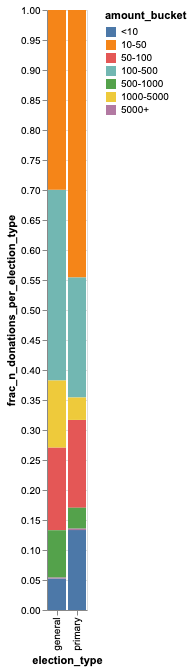

In [25]:
alt.Chart(gb2.execute()).mark_bar().encode(
    x="election_type:O",
    y="frac_n_donations_per_election_type:Q",
    color=bucket_col,
)

### By recipient

Let's look at the top players. Who gets the most donations?

Far and away it is ActBlue, which acts as a conduit for donations to Democratic
interests.

Beto O'Rourke is the top individual politician, hats off to him!

In [26]:
by_recip = summary_by(featured, "CMTE_NM")
by_recip

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ CMTE_NM                                                            ┃ n_donations ┃ total_amount ┃ mean_amount ┃ median_amount ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ string                                                             │ int64       │ int64        │ float64     │ int64         │
├────────────────────────────────────────────────────────────────────┼─────────────┼──────────────┼─────────────┼───────────────┤
│ BRIDGESTONE AMERICAS INC. PAC                                      │         384 │        42632 │  111.020833 │            50 │
│ CORELOGIC INC PAC                                                  │           4 │        11000 │ 2750.000000 │          2750 │
│ CROWLEY MARITIME CORPORATION FEDERAL PAC                           │        1137 │       192839 │  169.603342 │           100 │
│ NATIONAL PROPANE GAS ASSOCIATION POLITICAL ACTION COMMITTEE        │         475 │       198445 │  417.778947 │           152 │
│ BWX TECHNOLOGIES, INC POLITICAL ACTION COMMITTEE                   │        4839 │       431450 │   89.160984 │            64 │
│ CHEVRON EMPLOYEES POLITICAL ACTION COMMITTEE - CHEVRON CORPORATION │       12356 │       883848 │   71.531887 │            34 │
│ EMILY'S LIST                                                       │      174381 │     29222927 │  167.580912 │            50 │
│ OKLAHOMA STRONG LEADERSHIP PAC                                     │           2 │         5500 │ 2750.000000 │          2750 │
│ AMERICANS UNITED IN SUPPORT OF DEMOCRACY                           │          64 │       256300 │ 4004.687500 │          5000 │
│ AMERICAN SENIORS HOUSING ASSOCIATION (SENIORS HOUSING PAC)         │         341 │       805502 │ 2362.175953 │          2000 │
│ …                                                                  │           … │            … │           … │             … │
└────────────────────────────────────────────────────────────────────┴─────────────┴──────────────┴─────────────┴───────────────┘

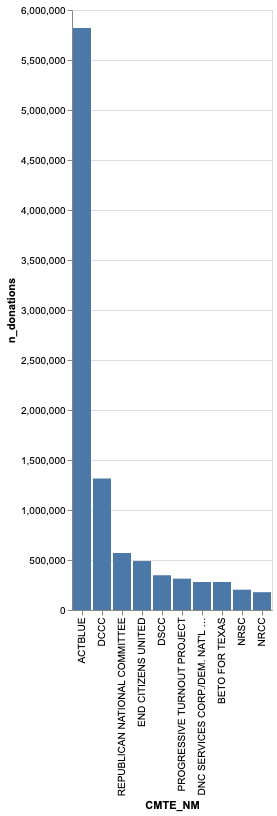

In [27]:
top_recip = by_recip.order_by(ibis.desc("n_donations")).head(10)
alt.Chart(top_recip.execute()).mark_bar().encode(
    x=alt.X("CMTE_NM:O", sort="-y"),
    y="n_donations:Q",
)

### By Location

Where are the largest donations coming from?

In [28]:
f2 = featured.mutate(loc=_.CITY + ", " + _.STATE).drop("CITY", "STATE")
by_loc = summary_by(f2, "loc")
# Drop the places with a small number of donations so we're
# resistant to outliers for the mean
by_loc = by_loc[_.n_donations > 1000]
by_loc

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ loc                 ┃ n_donations ┃ total_amount ┃ mean_amount ┃ median_amount ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ string              │ int64       │ int64        │ float64     │ int64         │
├─────────────────────┼─────────────┼──────────────┼─────────────┼───────────────┤
│ NORTHVILLE, MI      │        7926 │      1377925 │  173.848726 │            50 │
│ MISSOULA, MT        │       19647 │      3628034 │  184.660966 │            27 │
│ MIDDLETOWN, DE      │        1565 │       515802 │  329.585942 │            25 │
│ RALEIGH, NC         │       36381 │      6424836 │  176.598664 │            25 │
│ LOUISVILLE, KY      │       40812 │      8840210 │  216.608105 │            37 │
│ JACKSON HEIGHTS, NY │        2555 │       266927 │  104.472407 │            34 │
│ BROKEN ARROW, OK    │        3844 │       409471 │  106.522112 │            35 │
│ ARLINGTON, MA       │       12807 │      1967560 │  153.631608 │            38 │
│ CORALVILLE, IA      │        3318 │       284634 │   85.784810 │            25 │
│ CORNISH, NH         │        3026 │       140696 │   46.495704 │            25 │
│ …                   │           … │            … │           … │             … │
└─────────────────────┴─────────────┴──────────────┴─────────────┴───────────────┘

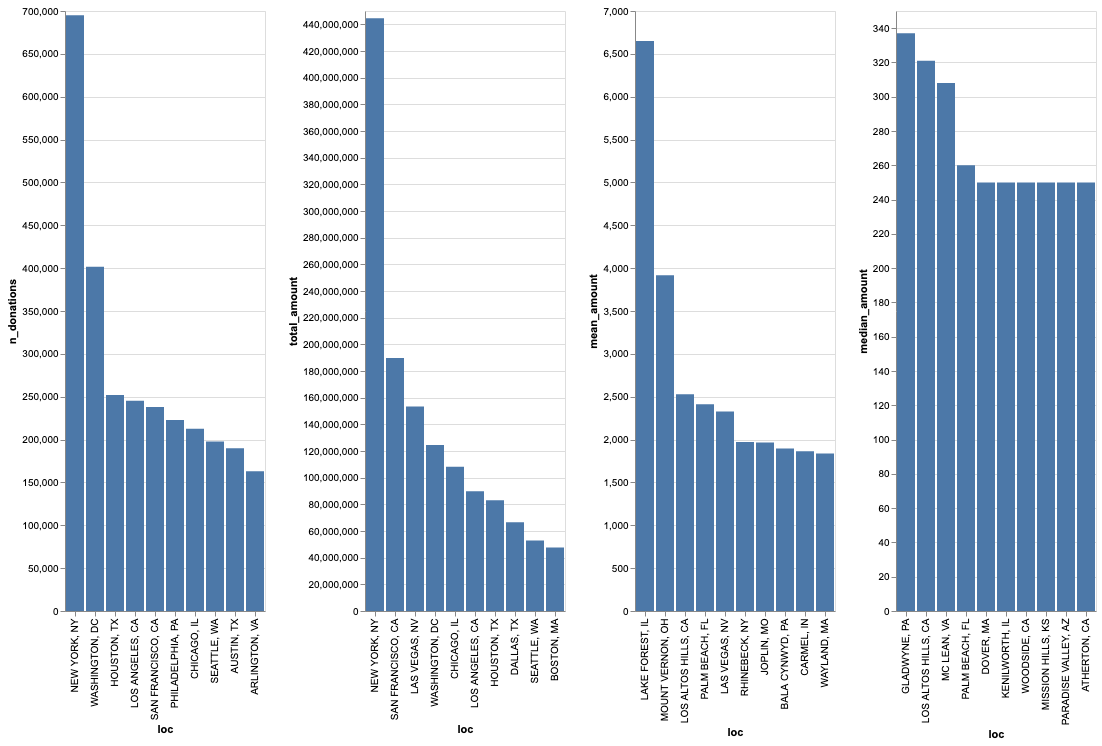

In [29]:
def top_by(col):
    top = by_loc.order_by(ibis.desc(col)).head(10)
    return (
        alt.Chart(top.execute())
        .mark_bar()
        .encode(
            x=alt.X('loc:O', sort="-y"),
            y=col,
        )
    )


top_by("n_donations") | top_by("total_amount") | top_by("mean_amount") | top_by(
    "median_amount"
)

### By month

When do the donations come in?

In [30]:
by_month = summary_by(featured, _.date.month().name("month_int"))
# Sorta hacky, .substritute doesn't work to change dtypes (yet?)
# so we cast to string and then do our mapping
month_map = {
    "1": "Jan",
    "2": "Feb",
    "3": "Mar",
    "4": "Apr",
    "5": "May",
    "6": "Jun",
    "7": "Jul",
    "8": "Aug",
    "9": "Sep",
    "10": "Oct",
    "11": "Nov",
    "12": "Dec",
}
by_month = by_month.mutate(month_str=_.month_int.cast(str).substitute(month_map))
by_month

┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ month_int ┃ n_donations ┃ total_amount ┃ mean_amount ┃ median_amount ┃ month_str ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ int32     │ int64       │ int64        │ float64     │ int64         │ string    │
├───────────┼─────────────┼──────────────┼─────────────┼───────────────┼───────────┤
│         ∅ │        1514 │       250297 │  165.321664 │           100 │ ∅         │
│         1 │      348979 │    174837854 │  500.998209 │           121 │ Jan       │
│         2 │      581646 │    255997655 │  440.126219 │           100 │ Feb       │
│         3 │     1042577 │    430906797 │  413.309326 │            81 │ Mar       │
│         4 │     1088244 │    299252692 │  274.986760 │            50 │ Apr       │
│         5 │     1374248 │    387317202 │  281.839378 │            48 │ May       │
│         6 │     1667285 │    465305247 │  279.079610 │            44 │ Jun       │
│         7 │     1607053 │    320528605 │  199.451172 │            35 │ Jul       │
│         8 │     2023466 │    473544182 │  234.026261 │            35 │ Aug       │
│         9 │     2583847 │    697888624 │  270.096729 │            38 │ Sep       │
│         … │           … │            … │           … │             … │ …         │
└───────────┴─────────────┴──────────────┴─────────────┴───────────────┴───────────┘

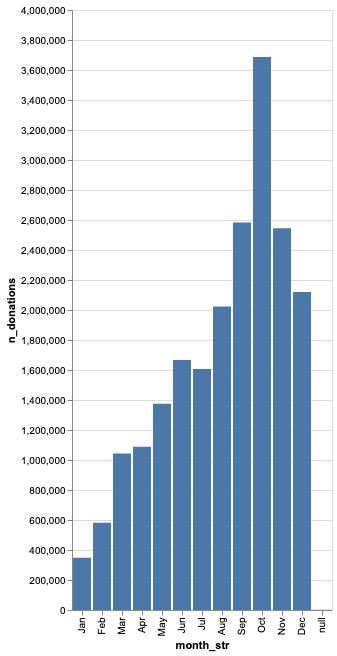

In [31]:
months_in_order = list(month_map.values())
alt.Chart(by_month.execute()).mark_bar().encode(
    x=alt.X("month_str:O", sort=months_in_order),
    y="n_donations:Q",
)

## Conclusion

Thanks for following along! I hope you've learned something about Ibis, and
maybe even about campaign finance.

Ibis is a great tool for exploring data. I now find myself reaching for it
when in the past I would have reached for pandas.

Some of the highlights for me:

- Fast, lazy execution, a great display format, and good type hinting/editor support for a great REPL experience.
- Very well thought-out API and semantics (e.g. `isinstance(val, NumericValue)`?? That's beautiful!)
- Fast and fairly complete string support, since I work with a lot of text data.
- Extremely responsive maintainers. Sometimes I've submitted multiple feature requests and bug reports in a single day, and a PR has been merged by the next day.
- Escape hatch to SQL. I didn't have to use that here, but if something isn't supported, you can always fall back to SQL.

Check out [The Ibis Website](https://ibis-project.org/) for more information.